In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchaudio.compliance import kaldi
import torch.nn.functional as F
import json, requests, timm
from collections import defaultdict

pd.set_option('display.max_columns', None)

In [2]:
class BirdAudioMAEDataset(Dataset):

    def __init__(self, df_audio_meta, dataset_dir, sampling_rate=16_000):
        self.df_audio_meta = df_audio_meta
        self.dataset_dir = dataset_dir
        self.sampling_rate = sampling_rate
        self.global_mean = -4.2677393
        self.global_std = 4.5689974

    def __len__(self):
        return len(self.df_audio_meta)

    def preprocess(self, x: torch.Tensor):
        x = x - x.mean()
        melspec = kaldi.fbank(x.unsqueeze(0), htk_compat=True, window_type="hanning", num_mel_bins=128)
        if melspec.shape[0] < 1024:
            melspec = F.pad(melspec, (0, 0, 0, 1024 - melspec.shape[0]))
        else:
            random_start = np.random.randint(0, len(melspec)-1025)
            melspec = melspec[random_start:random_start+1024]
        melspec = (melspec - self.global_mean) / (self.global_std * 2)
        return melspec

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.dataset_dir}/{row['file_name']}"
        # load audio file
        audio_arr, sr = librosa.load(audio_path, sr=self.sampling_rate)
        # get the spectrogram
        spec = self.preprocess(torch.tensor(audio_arr))
        return spec

In [3]:
TAG = "gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"
MODEL = timm.create_model(f"hf_hub:{TAG}", pretrained=True)

LABEL_URL = "https://huggingface.co/datasets/huggingface/label-files/raw/main/audioset-id2label.json"
AUDIOSET_LABELS = list(json.loads(requests.get(LABEL_URL).content).values())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
data_dir = "/workspace/voice_of_jungle/Audio_GreaterManaus_part_2"

df_audios = pd.read_csv(f'{data_dir}/metadata.csv')

df_audios = df_audios[~df_audios.isnull().any(axis=1)]
df_audios = df_audios[df_audios['file_name'].str.contains("wav")]
df_audios['file_exists'] = df_audios['file_name'].apply(lambda x: os.path.exists(f"{data_dir}/{x}"))

print(df_audios.shape)

# # index 8044 is broken
# df_audios = df_audios.drop(8044)
# df_audios = df_audios.reset_index(drop=True)

df_audios

(12498, 8)


,location,sub_location,location_id,timestamp,sampling_rate,mp3_path,file_name,file_exists
1,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:00:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T230000_44.wav,True
2,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:05:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T230500_36.wav,True
3,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:10:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T231000_34.wav,True
4,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:15:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T231500_31.wav,True
5,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:20:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T232000_42.wav,True
...,...,...,...,...,...,...,...,...
12500,Xingu,pidjo ko,Xingu_Pidjo_ko,2023-11-07 19:55:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Pidjo_ko_20231107T195500_36.wav,True
12501,Xingu,pidjo ko,Xingu_Pidjo_ko,2023-11-07 20:00:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Pidjo_ko_20231107T200000_39.wav,True
12502,Xingu,pidjo ko,Xingu_Pidjo_ko,2023-11-07 20:05:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Pidjo_ko_20231107T200500_20.wav,True
12503,Xingu,pidjo ko,Xingu_Pidjo_ko,2023-11-07 20:10:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Pidjo_ko_20231107T201000_26.wav,True


In [5]:
batch_size = 64

dataset = BirdAudioMAEDataset(df_audios, data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

probs_collect, classes_collect = [], []

MODEL.to(DEVICE)
MODEL.eval()

# ~ 1.5 hours
for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):

    # if i == 0:
    #     print("Example Spectrogram:")
    #     plt.figure(figsize=(9, 2))
    #     plt.imshow(data[0].numpy().T, aspect='auto', origin='lower', cmap='cool')
    #     plt.colorbar()
    #     plt.show()

    data = data.to(DEVICE)
    with torch.no_grad():
        logits = MODEL(data.unsqueeze(1))
        topk_probs, topk_classes = logits.sigmoid().topk(10)

    probs_collect.append(topk_probs.cpu().numpy())
    classes_collect.append(topk_classes.cpu().numpy())

    if (i+1) % 100 == 0:
        print(f"Finished {i+1} batches")

  0%|          | 0/196 [00:00<?, ?it/s]

Finished 100 batches


In [6]:
# aggregate all results
all_probs = np.concatenate(probs_collect)
all_classes = np.concatenate(classes_collect)

class_cols = [f'class_{i+1}' for i in range(10)]
proba_cols = [f'probability_{i+1}' for i in range(10)]

df_results = pd.DataFrame(
    np.concatenate([all_classes, all_probs], axis=1),
    columns = class_cols + proba_cols
)

df_results[class_cols] = df_results[class_cols].astype(int)
df_results[proba_cols] *= 100

id_to_label = {i: v for i, v in enumerate(AUDIOSET_LABELS)}
for _col in class_cols:
    df_results[_col] = df_results[_col].map(id_to_label)
    
df_audios_labels = df_audios.join(df_results, how='left').dropna()

display(df_audios_labels.head())

df_audios_labels.to_csv(f"{data_dir}/Audio_Segment_Labels.csv", index=False)

,location,sub_location,location_id,timestamp,sampling_rate,mp3_path,file_name,file_exists,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,probability_1,probability_2,probability_3,probability_4,probability_5,probability_6,probability_7,probability_8,probability_9,probability_10
1,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:00:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T230000_44.wav,True,Cricket,Insect,Animal,Raindrop,"Outside, rural or natural",Rain,Rain on surface,Snake,Frog,Bird,66.638339,56.651455,10.381946,9.999019,8.483265,6.688038,5.821190,5.620959,4.461668,4.342542
2,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:05:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T230500_36.wav,True,Insect,Cricket,Raindrop,Rain,"Outside, rural or natural",Snake,Rain on surface,Hiss,Animal,Steam,42.697513,35.240105,9.720138,7.632000,7.627760,7.163880,6.317802,4.989270,3.638322,1.810427
3,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:10:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T231000_34.wav,True,Insect,Cricket,"Outside, rural or natural",Animal,Snake,Raindrop,Hiss,Rain,Rain on surface,Environmental noise,53.267801,45.635137,11.613668,7.972876,7.147826,5.484055,5.233135,3.810843,3.364921,2.603415
4,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:15:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T231500_31.wav,True,Raindrop,Insect,Cricket,Rain,Rain on surface,"Outside, rural or natural",Hiss,Animal,Chime,Snake,20.740788,18.313628,13.509949,11.085254,10.213294,7.993856,4.930732,4.636838,4.234839,3.464121
5,Xingu,inore cot prut,Xingu_Inore_Cot_Prut,2023-11-10 23:20:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/X...,data/Xingu_Inore_Cot_Prut_20231110T232000_42.wav,True,Insect,Cricket,"Outside, rural or natural",Snake,Animal,Environmental noise,Hiss,Bird,Water,Silence,41.749424,36.688420,10.175224,9.886869,8.384907,3.517053,2.639829,2.459386,0.952673,0.933630


In [ ]:
# df_audios_labels = pd.read_csv(f"{data_dir}/Audio_Segment_Labels.csv")

# df_audios_labels

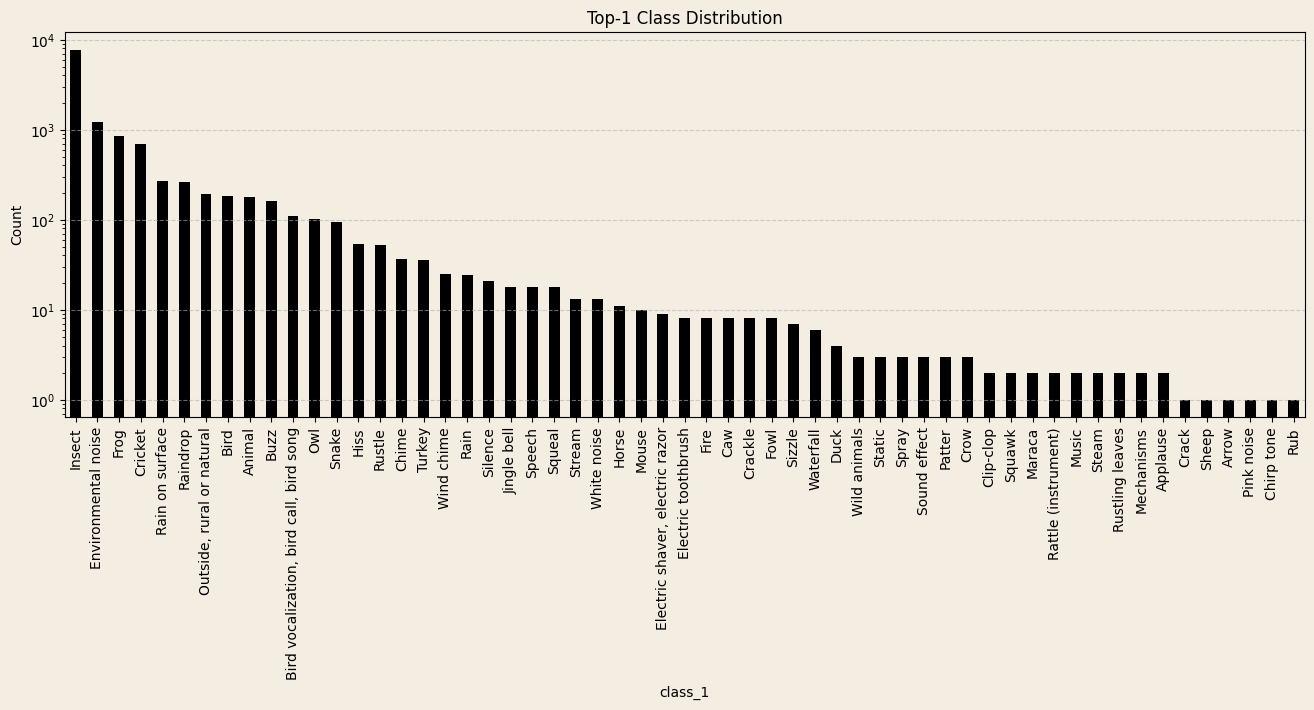

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
df_audios_labels['class_1'].value_counts().plot(kind='bar', ax=ax, color='k')
ax.set_ylabel("Count")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_title("Top-1 Class Distribution")
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.yscale('log')
plt.show()